# **Objective**
#### **In this project,** I aim to perform binary **image segmentation** on a **brain MRI** dataset using the **U-Net** model architecture. By creating a clear resource for implementing CNN based U-Net models, I hope to **demonstrate the power of deep learning** in **medical image analysis**, particularly in detecting and **masking abnormalities**, which are **crucial for medical diagnostics** and treatment planning. The chosen **dataset** contains brain MRI images, focusing on abnormality detection. Object segmentation, rather than detection, is emphasized to provide precise **delineation of abnormality boundaries**, a **vital parameter** in medical **decision-making**. Through this project, I seek to highlight the significance of accurate segmentation in medicine and showcase the efficacy of deep learning approaches, even with **limited datasets and computational resources**.

## **Dataset Structure:**
> ##### **The dataset** comprises brain MR images and manual FLAIR abnormality segmentation masks for 110 patients. **Each image is provided in '.tif' format with 3 channels**, corresponding to pre-contrast, FLAIR, and post-contrast sequences. Missing sequences are replaced with FLAIR to maintain consistency. **Masks are binary, single-channel images** delineating FLAIR abnormalities. **Some images may not exhibit any abnormalities**, resulting in entirely **black masks**. This characteristic allows for the identification of images with **negative diagnoses**. Patient data and abnormality genomic clusters are available in data.csv, though **unused** in this project. **Refer to the dataset page for more details.**


## **U-Net Model Overview:**
> ##### **The U-Net model** is a **CNN architecture** specifically tailored for biomedical **image segmentation** tasks, such as identifying abnormalities in brain MRI scans. Its distinctive **encoder-decoder structure** enables efficient mapping of **three-channel MRI images** to **one-channel segmentation masks**. The encoder extracts features from the input images, while the decoder reconstructs the masks, effectively **highlighting areas of abnormality**. This architecture preserves spatial information and detail, making it **well-suited for accurate segmentation** in this project.
> 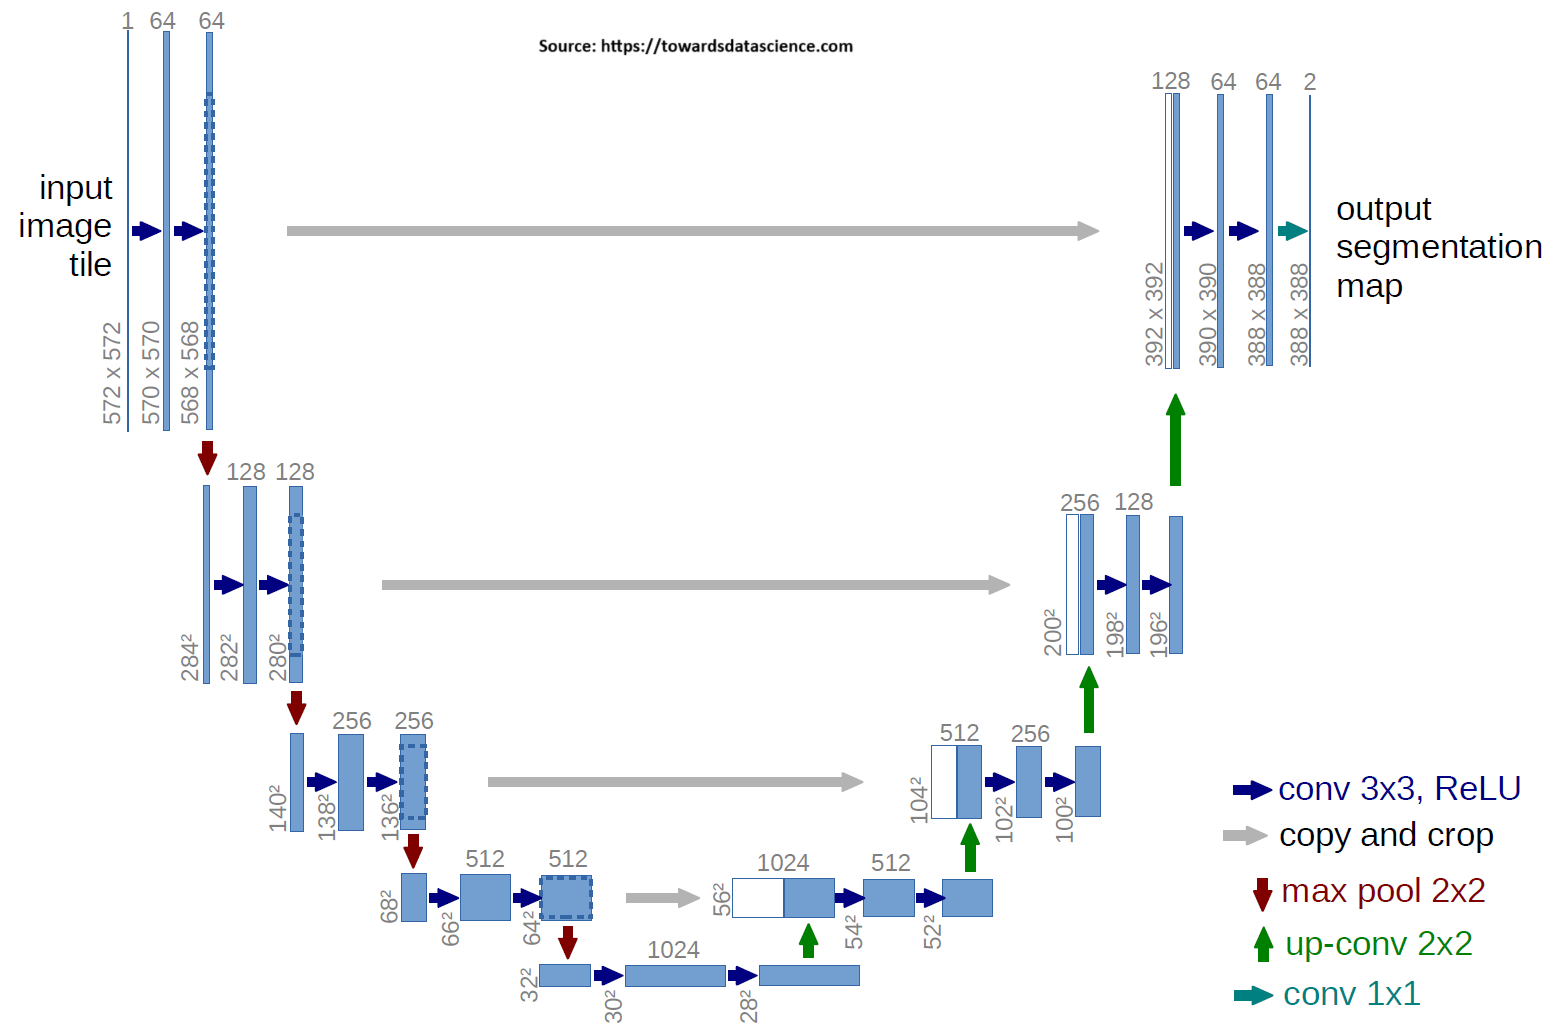

## **Methodology**
> #### 1. **Data Loading and Pre-processing:**
> ##### This phase **involves gathering image and mask paths, organizing them into dataframes, and extracting necessary information** such as MRI IDs and diagnoses. Additionally, **visualizations** are generated to provide **insights into** the dataset's composition and class distribution.

> #### 2. **Data Setup for Model Input:**
> ##### During data setup, **'.tif'** images are transformed into **tensors**, resized, and normalized. The data is then organized into batches, shuffled, and paired with corresponding masks before being prefetched for efficient model input. This process ensures proper data **formatting** and **optimization** for model training.

> #### 3. **Defining the U-Net Model:**
> ##### **The U-Net model architecture** is crafted with an **encoder-decoder** structure, comprising **convolutional blocks** for **feature extraction** and **upsampling blocks** for **decoding**. Between the encoder and decoder, a bridge consolidates information flow. **Residual connections** are employed to preserve crucial features throughout the network. **The model is tuned** with a **learning rate** of 0.0003 and mean squared error as the **loss function**, optimized through iterative training.

> #### 4. **Training:**
> ##### **The training process** involves iteratively **adjusting the weights** of the U-Net model to **minimize the disparity** between predicted and ground truth segmentation masks. **Checkpoint and early stopping callbacks** are employed to preserve the **best-performing weights** and **halt training** if performance stagnates, respectively.

> #### 4. **Inference:**
> ##### **The inference step** involves **evaluating** the trained U-Net model on the test dataset to assess its **segmentation and classification performance**. Utilizing metrics such as **Intersection over Union (IoU)**, the model's **accuracy in predicting masks** is evaluated, while also assessing its **ability to classify input data**. **Visualizations** aid in understanding model predictions, including **comparisons between actual and predicted masks**, as well as classification metrics such as **confusion matrices and classification reports**.

## Library setup
> ##### At this notebook, **Keras and TensorFlow** will be utilized for **model development** and training, leveraging their robust libraries and functionalities.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow as tf
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Data Loading and Pre-processing**
> * **The process** begins by **loading the paths** of both the images and masks from **all folders** and organizing them into **one list**. This list is then passed to a **function** called **data_frame()** to create **train, validation, and test dataframes**. Within this function, the images (identified by **paths not ending with '_mask'**) are selected and **sorted** based on the MRI number and patient IDs. **Similarly**, masks (identified by **paths ending with '_mask'**) undergo the **same sorting process**. Additionally, the **ID** of each MRI **is recorded**.


> * Since **some images may not exhibit any abnormalities**, this information is extracted by **checking if the mask contains any pixel values larger than 0**.


> * **The outputs of this function are 3 dataframes containing IDs, images, masks, and diagnoses for each MRI.**


> * Several **visualizations** are conducted to aid in understanding the dataset. These include separate visualizations for **positive MRIs and negative MRIs**. Additionally, a visualization depicting the **class distribution** across train, test, and validation dataframes is generated to illustrate the **proportion of positive and negative data within each dataset split**.

In [ ]:
# Path to the images and masks
IMAGE_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

# Size of the images and masks
IMAGE_SIZE = (256, 256)

# Number of epochs
EPOCHS = 60

# Batch size
BATCH_SIZE = 45

In [ ]:
# A list to hold each image and mask's path
paths = []

for dirname in os.listdir(IMAGE_PATH):
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):
        
        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Only the files with ',tif' format should be added to the 'paths' list
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH+'/'+dirname+'/'+filename)

len(paths), paths[:20:5]

## **Making dataframes**

In [ ]:
# Making a dataframe from the list "paths" by separating Images and Masks, extracting IDs, and diagnoses.
def data_frame(data):
    # Storing only paths that don't end with 'mask.tiff'
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Sorting images based on the number of each MRI.
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    
    # Storing the image IDs
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # Storing only paths that end with 'mask.tiff'
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Sorting masks based on the number of each MRI.
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Sorting by the patient IDs (each patient has more than 1 MRIs)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Opens the images
    pixels = lambda x: Image.open(x)
    # Selects the largest pixel
    largest_pixel = lambda y: np.max(pixels(y))
    # Determines if the mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Storing the diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Making the dataframe
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})
    
    # Dividing the indexes into train, test, and validation
    train_index, val_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.19, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.12, random_state=42)
    
    # Making train, test, and validation dataframes
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]
    
    return train_df, val_df, test_df
    
# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

train_df.head()

## **Visualization**

#### **Positive Images and Masks**

In [ ]:
def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    num_samples = len(images)
    # Checking whether the function has been given the prediction array or not
    num_rows = 2 if type(predictions) == type(None) else 3
    
    # Defining figure
    fig, axes = plt.subplots(num_rows, num_samples,
                             figsize=(num_samples*5, num_samples+(num_rows*2)), dpi=200)
    
    for i in range(num_samples):
        # Plotting image
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')
        axes[0, i].set_title('Image', fontsize=20, fontweight='bold')
        axes[0, i].axis('off')
        
        # Plotting mask
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')
        axes[1, i].set_title('Mask', fontsize=20, fontweight='bold')
        axes[1, i].axis('off')
        
        # Plotting prediction
        if type(predictions) != type(None):
            axes[2, i].imshow(predictions[i], cmap='gray')
            axes[2, i].set_title(f'Prediction | IoU: {round(float(IoU_list[i]), 3)}',
                                 fontsize=19, fontweight='bold')
            axes[2, i].axis('off')
             
    # Adding title
    plt.suptitle('Images and Masks', fontsize=30, fontweight='bold')
    
    # Showing the figure
    plt.show()

plot_images_and_masks(train_df[train_df['Diagnosis'] == 1]['Image'].values[:6],
                      train_df[train_df['Diagnosis'] == 1]['Mask'].values[:6])

#### **Negative Images and Masks**

In [ ]:
plot_images_and_masks(train_df[train_df['Diagnosis'] == 0]['Image'].values[:6],
                      train_df[train_df['Diagnosis'] == 0]['Mask'].values[:6])

### **Class Distribution**

In [ ]:
def plot_class_distribution(train_df, val_df, test_df):
    # Counting the class distribution for every dataframe.
    class_distribution_df1 = train_df['Diagnosis'].value_counts()
    class_distribution_df2 = val_df['Diagnosis'].value_counts()
    class_distribution_df3 = test_df['Diagnosis'].value_counts()
    
    colors = ['#0504AA', '#ED0101']

    # Defining figure
    fig = go.Figure()

    # Adding bars for each dataframe and each class
    for class_label in class_distribution_df1.index:
        # Getting the name of each class (+ or -)
        class_name = 'Positive' if class_label == 1 else 'Negative'
        
        # Creating stacked bar for each class
        fig.add_trace(go.Bar(
            x=['Training', 'Validation', 'Test'],
            y=[class_distribution_df1.get(class_label, 0),
               class_distribution_df2.get(class_label, 0),
               class_distribution_df3.get(class_label, 0)],
            
            name=f'{class_name}',
            marker=dict(color=colors[class_label]),
            opacity=0.75,
            width=0.3
        ))
    
    # Updating layout
    fig.update_layout(
        height=700,
        width=800,
        title_text="Class Distribution",
        title_font=dict(size=25, family='Balto'),
        title_x=0.5,
        title_y=0.98,
        xaxis=dict(title='Dataframes', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        yaxis=dict(title='Count', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        margin=dict(l=60, r=20, t=50, b=40), 
        legend=dict(x=0.73, y=0.98, traceorder='normal', orientation='h', font=dict(family='Balto')),  # Placing legend inside
        barmode='stack'  # Setting barmode to 'stack' to stack the bars
                )
    # Showing the figure
    fig.show()

plot_class_distribution(train_df, val_df, test_df)

##### **Almost 70% of data belong to the negative class**

# **Data Setup for Model Input**
> * **At this part**, the **'.tif'** images are **decoded** into NumPy arrays and converted **into tensors** using TensorFlow. Following this, both the images and masks are **resized** ((256, 256, **3**) for images and (256, 256, **1**) for masks). Normalization is applied to the tensor values by dividing them by 255.


> * Subsequently, the data is passed to the 'tf.data.Dataset.from_tensor_slices()' function, shuffled, paired (matching images with their corresponding masks), and batched. The batched data is **prefetched** for efficient model input, **overlapping** data pre-processing with model training to **optimize resource utilization** and **enhance training speed**.


> * **This process ensures** that the data is **appropriately formatted** and optimized **for input into the model**.

In [ ]:
# Processes the image
def decode_and_resize_image(img_path):
    # Reading '.tiff' format image
    img = tf.io.read_file(img_path)
    with tf.io.gfile.GFile(img_path, 'rb') as f:
        img = Image.open(f)
        img = np.array(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE, preserve_aspect_ratio=True)
    
    # Normalizing the image to the range [0, 1]
    img = img / 255.0
    
    # Pbar updating, started at the data setup cell.
    try:
        pbar.update(1)
    except:
        pass
    
    return img

# Processes the mask
def decode_and_resize_mask(mask_path):
    # Reading '.tiff' format masks
    mask = tf.io.read_file(mask_path)
    with tf.io.gfile.GFile(mask_path, 'rb') as f:
        mask = Image.open(f)
        mask = np.array(mask)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    mask = np.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest', preserve_aspect_ratio=True)
    grayscale_mask = tf.reduce_mean(mask, axis=-1, keepdims=True)
    
    # Normalizing the mask to the range [0, 1]
    grayscale_mask = grayscale_mask / 255.0
    
    # Pbar updating, started at the data setup cell.
    try:
        pbar.update(1)
    except:
        pass
    
    return grayscale_mask

In [ ]:
def processed_input(img, mask):
    # Processed images: (None, 256, 256, 3), Processed masks: (None, 256, 256, 1)
    return img, mask

# Prepares the dataset
def make_dataset(images, masks):
    dataset = tf.data.Dataset.from_tensor_slices((list(map(lambda x: decode_and_resize_image(x), images)),
                                                 list(map(lambda x: decode_and_resize_mask(x), masks))))
    # Shuffle dataset
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    # Map dataset
    dataset = dataset.map(processed_input, num_parallel_calls=tf.data.AUTOTUNE)
    # While the current batch of data is being processed, prefetching the next batch based on available resources.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

# Defining  a Pbar to keep an eye on the procedure.
pbar = tqdm(total=(len(train_df)+len(val_df))*2, position=0, leave=True, colour='green')

# Making the datasets by providing the lists of corresponding masks and images.
train_dataset = make_dataset(list(train_df['Image'].values), list(train_df['Mask'].values))
validation_dataset = make_dataset(list(val_df['Image'].values), list(val_df['Mask'].values))

pbar.close()

##### Now **the datasets are prepared** in the desired format. Images and masks have been processed, paired, and put into batches.

# **Defining the U-Net Model**
> **The U-Net model** is defined using a **series of convolutional blocks** for both the encoder and decoder sections.
> * **The encoder** consists of 4 convolutional blocks, each containing **Conv2D layers** followed by **Batch Normalization, Leaky ReLU activation**, and **Max Pooling 2D** operations.


> * **Between the encoder and decoder**, a bridge is established with **Conv2D layers, Batch Normalization**, and **Leaky ReLU** activation to facilitate information flow.


> * In **the decoder** section, 4 upsampling blocks are applied, each containing **Conv2DTranspose** layers for upsampling, **concatenation for residual connections**, and the previously mentioned **convolutional blocks**. **Residual connections** allow the network to **retain** high-resolution **features from the encoder** while progressing **through the decoder**.


> * **Finally**, the output part of the model consists of a **Conv2D** layer followed by **Batch Normalization**, **Leaky ReLU** activation, and a final **Conv2D** layer.


> * **The learning rate and loss function** hyperparameters were **fine-tuned** through multiple training sessions, **resulting in** the selection of a **learning rate of 0.0003 and mean squared error as the loss function**. While **IoU error and binary cross-entropy are commonly suggested for such projects, mean squared error** was found to yield **better performance in this case**.


> * This architecture leverages the U-Net design principles to effectively capture both global and local features while preserving spatial information, thereby enabling accurate segmentation of abnormalities in the brain MRI images.

In [ ]:
# Convolutional block
def conv_block(inputs, n_filters, max_pool=True):
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# upsampling block
def up_block(reg_inputs, skip_inputs, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding='same')(reg_inputs)
    x = concatenate([x, skip_inputs], axis=3)
    x = conv_block(x, n_filters, max_pool=False)[0]
    return x

# U-Net model
def unet(input_size=(256, 256, 3)):
    # Encoder block
    inputs = Input(shape=input_size, name='Input')
    cb1, cb1_skip = conv_block(inputs, 32)
    cb2, cb2_skip = conv_block(cb1, 64)
    cb3, cb3_skip = conv_block(cb2, 128)
    cb4, cb4_skip = conv_block(cb3, 256)
    cb5 = conv_block(cb4, 512, max_pool=False)
    
    # Decoder block
    up1 = up_block(cb5[0], cb4_skip, 256)
    up2 = up_block(up1, cb3_skip, 128)
    up3 = up_block(up2, cb2_skip, 64)
    up4 = up_block(up3, cb1_skip, 32)
    
    # Output
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    act = LeakyReLU(0.2)(bn)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid', name='Output')(act)
    
    # Creating the model
    unet = Model(inputs=inputs, outputs=outputs)
    
    # Compiling the model
    unet.compile(optimizer=keras.optimizers.Adam(3e-4), loss='mean_squared_error')
    
    return unet

# Creating the model
model = unet()

# Plotting the model
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

# **Training**
> **During training**, the U-Net model **adjusts its weights** to **minimize the discrepancy between the predicted** segmentation masks **and the ground truth** masks.


> * **The training process spans 60 epochs**, allowing the model **sufficient time** to iteratively refine its weights. **A small learning rate** facilitates gradual weight updates, **aiding in the convergence towards optimal solutions**.


> * Additionally, a **checkpoint callback** is implemented to save the model weights whenever improvements are detected at each epoch, ensuring that the **best-performing** weights are preserved.


> * Furthermore, an **early stopping callback** is utilized to halt the training process **if the model fails to demonstrate improvements in weight optimization** after 6 consecutive epochs.


> * This strategy helps prevent overfitting and ensures that training concludes efficiently once the model reaches its optimal performance.


> * After training, **a plot visualizes** the changes in **training loss and validation loss** across epochs, providing insights into model performance and convergence.

In [ ]:
# Path to save the best weights
checkpoint_path = "best_model.weights.h5"

# Defining ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

# Defining EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Training the model
history = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=EPOCHS, callbacks=[early_stopping, checkpoint_callback])

# Loading the best weights
model.load_weights("best_model.weights.h5")

#### **Visualizing model's performance**

In [ ]:
def plot_history(history):
    plots = go.Figure([go.Scatter(x=[x+1 for x in range(EPOCHS)], y=history.history['loss'],
                                  name='Training Loss',mode='lines+markers',
                                  marker=dict(color='#00008B'),line=dict(width=1),showlegend=True),

                       go.Scatter(x=[x+1 for x in range(EPOCHS)], y=history.history['val_loss'],
                                  name='Validation Loss',mode='lines+markers',
                                  marker=dict(color="#004EFF"),line=dict(width=1),showlegend=True)])

    plots.update_layout(
        title_text="Training vs Validation",
        title_font=dict(size=25, family='Balto'),
        title_x=0.5,
        title_y=0.98,
        xaxis=dict(title='Epoch', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        yaxis=dict(title='Loss', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        margin=dict(l=60, r=20, t=50, b=40),
        legend=dict(x=0.75, y=0.98, traceorder='normal', orientation='h', font=dict(family='Balto'))  # Placing legend inside
    )

    plots.show()
    
plot_history(history)

##### The model is **well-trained** and there is **no sign of over fitting** on train data.

# **Inferece**
> Although **Intersection over Union (IoU) is not chosen as a training metric**, **it is utilized during inference** to evaluate predicted masks, showcasing its accuracy in assessing **the similarity between predicted and actual masks**.
> * **Intersection over Union (IoU):** IoU is a measure of **overlap between two binary masks**, calculated by **dividing the area of overlap by the area of union**, quantifying the extent of agreement between predicted and ground truth masks.
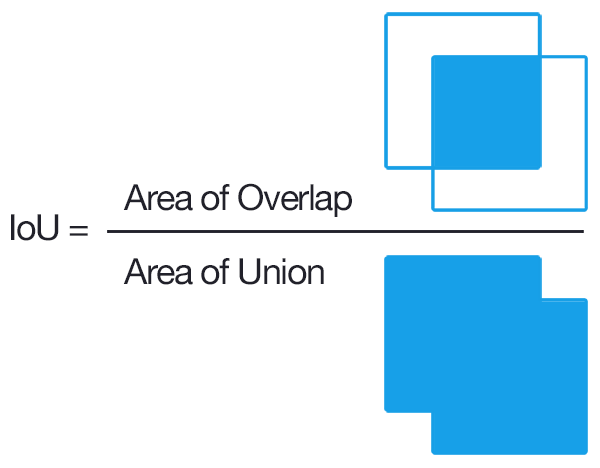


> * **Prediction:** The **predictions()** function **decodes** images and actual masks from a provided **test dataframe** and **predicts the corresponding masks**. Predicted masks are **thresholded to produce binary values**, with 1 indicating values larger than 0.5 and 0 otherwise. **IoU is computed for each predicted mask**, enabling assessment of segmentation accuracy. Furthermore, **the function performs classification** on input data, distinguishing between negative and positive diagnoses based on predicted masks.


> * **Classification:** **As the model also performs classification**, evaluation metrics such as **confusion matrix and classification report** are applied. **Due to the small size of the test dataset, validation data is added to the test dataset for a more comprehensive evaluation**. The predictions() function is called again, this time on the combined test and validation dataframes, to assess classification metrics.


> * **Visualization:** Visualization of 24 positive and 24 negative **images, along with their actual and predicted masks**, offers insights into model performance. **Also, Visualizations for classification part** include plots illustrating **class distribution, confusion matrix, and classification report**, enabling thorough evaluation of model performance.

In [ ]:
# Calculates IoU
def IoU(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersection
    IoU = (intersection + 1e-25) / (union + 1e-25)  # Adding a small epsilon to avoid division by zero
    return IoU

# Returns a dataframe containing the IDs, the actual diagnoses, the predicted diagnoses, and IoU for each prediction,
# along with a dictionary of masks associated with each ID.
def predictions(df, threshold=0.5):
    x = np.array(list(map(lambda v: decode_and_resize_image(v), df['Image'])))
    y = np.array(list(map(lambda v: decode_and_resize_mask(v), df['Mask'])))
    
    # Predicting the masks
    pred = model.predict(x)
    
    # Thresholding predicted mask values
    pred_thresholded = tf.cast(pred > threshold, dtype=tf.float32)
    
    # Getting each mask's IoU
    IoUs = IoU(y, pred_thresholded).numpy()
    IoUs = list(map(lambda x: round(x, 3), IoUs))
    
    # Takes the largest pixel
    largest_pixel = lambda y_: np.max(y_)
    
    # Determines if the predicted mask contains an abnormality or not (+ or -)
    # Remember that a negative image's mask is just an entirely black image.
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    
    # Storing the predicted diagnosis corresponding to each image
    diagnoses = list(map(lambda x: diagnotic_function(x), pred_thresholded))
    
    # Prediction dataframe (Diagnoses and IoUs)
    prediction_df = pd.DataFrame({'ID': df['ID'].values, 'Actual Diagnosis': df['Diagnosis'].values,
                                  'Predicted Diagnosis': diagnoses, 'IoU': list(IoUs)})
    
    # Prediction dictionary (ID: array of mask values)
    prediction_dict = {}
    for i, j in zip(df['ID'].values, pred_thresholded):
        prediction_dict[i] = j
    
    return prediction_dict, prediction_df

# Making predictions
prediction, prediction_df = predictions(test_df)

print(len(prediction), list(prediction.values())[0].shape)

prediction_df.head()

In [ ]:
prediction_df.describe()

##### As you can see, **the IoU** scores have an **acceptable mean value**.

In [ ]:
# IDs for 24 Positive Diagnoses
positive_ids = list(test_df[test_df['Diagnosis'] == 1]['ID'][:24].values)
# IDs for 24 Negative Diagnoses
negative_ids = list(test_df[test_df['Diagnosis'] == 0]['ID'][:24].values)

## **Visualization**

#### **Positive Images and Masks**

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in positive_ids[:8]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in positive_ids[:8]],
                      [prediction[ID].numpy() for ID in positive_ids[:8]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in positive_ids[:8]])

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in positive_ids[8:16]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in positive_ids[8:16]],
                      [prediction[ID].numpy() for ID in positive_ids[8:16]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in positive_ids[8:16]])

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in positive_ids[16:]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in positive_ids[16:]],
                      [prediction[ID].numpy() for ID in positive_ids[16:]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in positive_ids[16:]])

#### **Negative Images and Masks**

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in negative_ids[:8]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in negative_ids[:8]],
                      [prediction[ID].numpy() for ID in negative_ids[:8]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in negative_ids[:8]])

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in negative_ids[8:16]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in negative_ids[8:16]],
                      [prediction[ID].numpy() for ID in negative_ids[8:16]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in negative_ids[8:16]])

In [ ]:
plot_images_and_masks([test_df.loc[test_df['ID'] == ID, 'Image'].values[0] for ID in negative_ids[16:]],
                      [test_df.loc[test_df['ID'] == ID, 'Mask'].values[0] for ID in negative_ids[16:]],
                      [prediction[ID].numpy() for ID in negative_ids[16:]],
                     [prediction_df.loc[prediction_df['ID'] == ID, 'IoU'].values[0] for ID in negative_ids[16:]])

##### The model can **detect negative MRIs accurately**, which makes it **an excellent classifier** too.

##### As I mentioned earlier, **more data is necessary** to improve the understanding of **classification evaluations**. So, I combine **the validation and test dataframes**.

In [ ]:
# Making predictions
prediction, prediction_df = predictions(pd.concat([test_df, val_df], ignore_index=True))

print(len(prediction), list(prediction.values())[0].shape)

prediction_df.head()

In [ ]:
prediction_df.describe()

##### **Adding validation dataframe** to test dataframe **doesn't change the IoU mean value significantly**, which means we can use the validation data as unseen data as well.

### Class Distribution

In [ ]:
def plot_class_distribution(df):
    # Counting the actual and predicted class distributions (+, -).
    class_distribution_df1 = df['Actual Diagnosis'].value_counts()
    class_distribution_df2 = df['Predicted Diagnosis'].value_counts()
    mean_IoU = round(df['IoU'].mean(), 3)
    
    colors = ['#0504AA', '#ED0101']

    # Defining figure
    fig = go.Figure()

    # Adding bars for each dataframe and each class
    for class_label in class_distribution_df1.index:
        # Getting the name of each class (+ or -)
        class_name = 'Positive' if class_label == 1 else 'Negative'
        
        # Creating stacked bar for each class
        fig.add_trace(go.Bar(
            x=['Actual', 'Predicted'],
            y=[class_distribution_df1.get(class_label, 0),
               class_distribution_df2.get(class_label, 0)],
            
            name=f'{class_name}',
            marker=dict(color=colors[class_label]),
            opacity=0.75,
            width=0.25
        ))
    
    # Updating layout
    fig.update_layout(
        height=700,
        width=800,
        title_text=f"Class Distribution | IoU {round(float(mean_IoU), 4)}",
        title_font=dict(size=25, family='Balto'),
        title_x=0.5,
        title_y=0.98,
        xaxis=dict(title='Columns', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        yaxis=dict(title='Count', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
        margin=dict(l=60, r=20, t=50, b=40), 
        legend=dict(x=0.38, y=0.98, traceorder='normal', orientation='h', font=dict(family='Balto')),  # Placing legend inside
        barmode='stack'  # Setting barmode to 'stack' to stack the bars
                )
    # Showing the figure
    fig.show()
    
plot_class_distribution(prediction_df)

## Classification metrics

In [ ]:
# Plots Confusion Matrix
def Confusion_Matrix(df):
    confusionMatrix = confusion_matrix(df['Actual Diagnosis'], df['Predicted Diagnosis'])

    # Defining class names
    class_names = ['Negative', 'Positive']

    # Normalizing confusion matrix
    confusionMatrixNormalized = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]

    # Creating heatmap trace for confusion matrix
    heatmap_trace = go.Heatmap(z=confusionMatrixNormalized,
                               x=class_names,
                               y=class_names,
                               colorscale='Viridis',
                               colorbar=dict(title='Proportion', title_font=dict(family='Balto'),
                                             tickfont=dict(family='Balto'), tickformat='.2f'))

    # Creating text annotations for each cell in the heatmap
    annotations = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            annotations.append(dict(text=str(confusionMatrix[i, j]),
                                    x=class_names[j],
                                    y=class_names[i],
                                    showarrow=False,
                                    font=dict(color='black', family='Balto', size=25)))

    # Creating layout
    layout = go.Layout(height=700,
                       width=800,
                       title='Confusion Matrix',
                       title_font=dict(size=25, family='Balto'),
                       title_x=0.5,
                       title_y=0.95,
                       xaxis=dict(title='Predicted label', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
                       yaxis=dict(title='True label', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
                       annotations=annotations)

    # Creating figure
    fig = go.Figure(data=[heatmap_trace], layout=layout)

    # Showing the plot
    fig.show()
    
Confusion_Matrix(prediction_df)

In [ ]:
# Rounds the number of Classification Report output
def round_dict(d, decimals=2):
    if isinstance(d, dict):
        return {key: round_dict(value, decimals) for key, value in d.items()}
    else:
        return round(d, decimals)

# Plots Classification Report
def Classification_Report(df):
    clf_report = classification_report(df['Actual Diagnosis'],
                                       df['Predicted Diagnosis'],
                                       labels=np.arange(2),
                                       target_names=['Negative', 'Positive'],
                                       output_dict=True)

    rounded_data = round_dict(clf_report, decimals=2)

    # Converting classification report data to dataframe
    df_clf_report = pd.DataFrame.from_dict(rounded_data)

    # Transposing dataframe for proper visualization
    df_clf_report = df_clf_report.T

    # Reversing the order of rows in the dataframe
    df_clf_report = df_clf_report.iloc[::-1]

    # Creating heatmap trace for classification report
    heatmap_trace = go.Heatmap(z=df_clf_report.values[:, :-1],  # Excluding 'support' column
                               x=df_clf_report.columns[:-1],  # Excluding 'support' column
                               y=df_clf_report.index,
                               colorscale='Viridis')

    # Creating text annotations for each cell in the heatmap
    annotations = []
    for i in range(len(df_clf_report.index)):
        for j in range(len(df_clf_report.columns) - 1):
            annotations.append(dict(text=str(df_clf_report.values[i, j]),
                                    x=df_clf_report.columns[j],
                                    y=df_clf_report.index[i],
                                    showarrow=False,
                                    font=dict(color='black', family='Balto', size=22)))

    # Creating layout
    layout = go.Layout(height=800,
                       width=800,
                       title='Classification Report',
                       title_font=dict(size=25, family='Balto'),
                       title_x=0.5,
                       title_y=0.95,
                       xaxis=dict(title='Metrics', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
                       yaxis=dict(title='Class', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
                       annotations=annotations)

    # Creating figure
    fig = go.Figure(data=[heatmap_trace], layout=layout)

    # Showing the plot
    fig.show()
    
Classification_Report(prediction_df)

## **As we can see, the model can provide both excellent segmentations and accurate classifications.**

### **Thank you** for taking the time to explore this notebook. I hope you found it both **enjoyable** and **informative**. **Please consider upvoting, sharing,** and **trying out** the concepts presented. **Feel free to share your thoughts, questions, or suggestions** in the **comment section** below.

# **Happy coding!**